In [1]:
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
from munch import Munch

import datasets
import models
import transforms
import utils

In [2]:
config_path = 'pretrained/drn_d_22_OilChange/config.yml'

In [3]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [4]:
model = models.DRNSeg(cfg.arch, cfg.data.classes, None, pretrained=True)
model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True
checkpoint = torch.load(cfg.training.resume)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("=> loaded checkpoint '{}' (epoch {})".format(cfg.training.resume, checkpoint['epoch']))

=> loaded checkpoint 'pretrained/drn_d_22_OilChange/checkpoint_00000900.pth.tar' (epoch 900)


In [5]:
val_transforms = transforms.Compose([transforms.ToTensor()])

In [6]:
val_dataset = datasets.Dataset(cfg.data.root, 'val_' + cfg.data.ann_file, 'val', val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


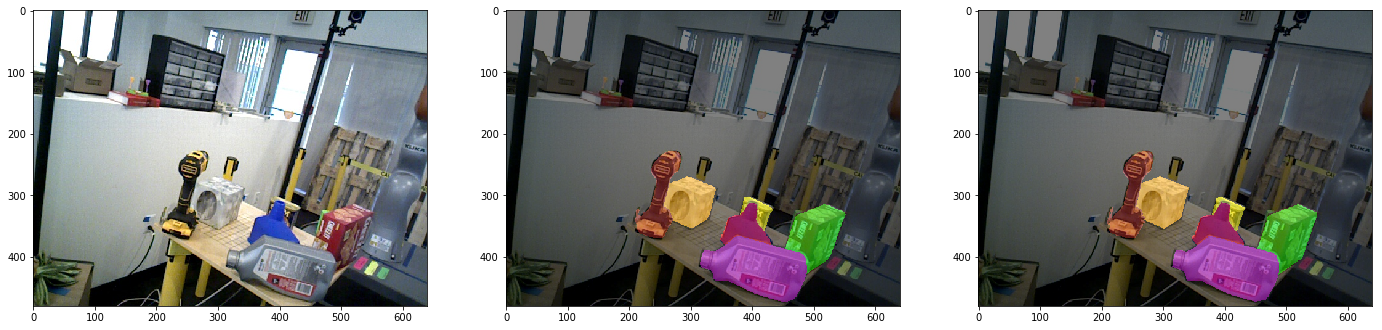

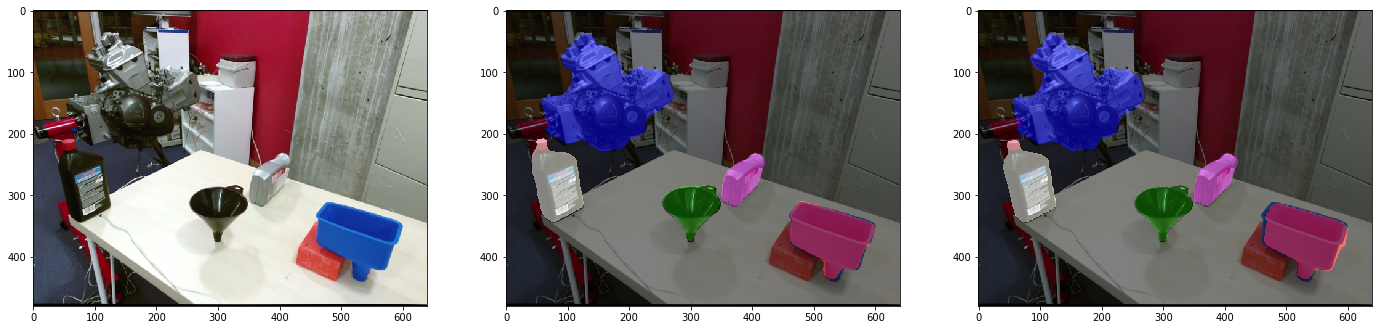

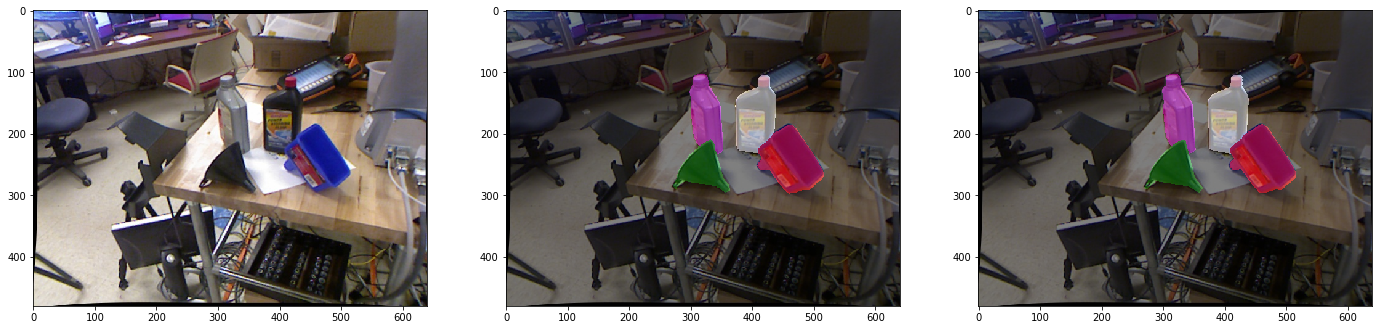

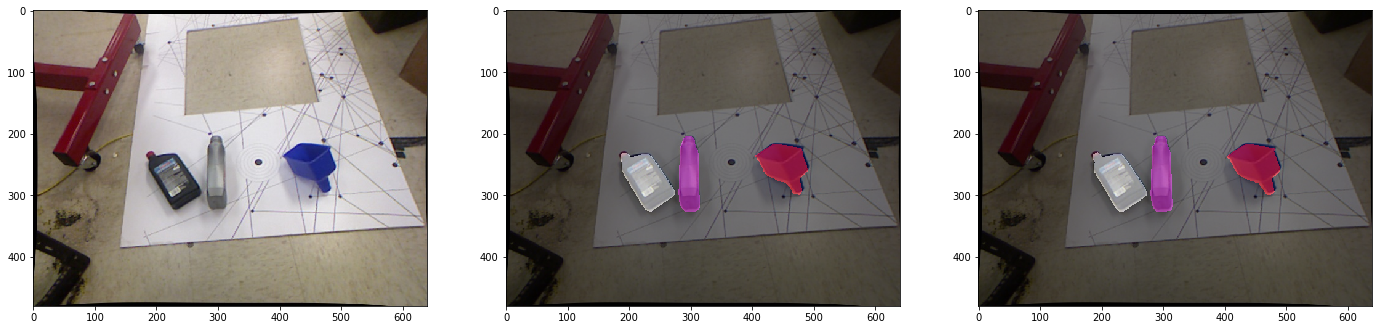

In [7]:
# display random sets of (input image, output segmentation, and target segmentation)
count = 0
num_examples = 4

with torch.no_grad():
    for input, target in val_loader:
        output = model(input)
        _, output = output.max(1)
        output = output.cpu().data.numpy()
        input = input.permute(0, 2, 3, 1).numpy()
        target = target.numpy()
        for i in range(input.shape[0]):
            fig, axes = plt.subplots(1, 3, figsize=(3 * 8, 8))
            axes[0].imshow(input[i])
            utils.visualize(axes[1], input[i], output[i])
            utils.visualize(axes[2], input[i], target[i])
            plt.show()

        count += input.shape[0]
        if count == num_examples:
            break